In [1]:
%reload_ext autoreload
%autoreload 2

# number of neighbors by AUC

In [ ]:
from pathlib import Path
import sys
import random
from concurrent.futures import ProcessPoolExecutor, wait

from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.predict import predict_by_flann


def process(n_neighbors):
    scop_root = Scop(dir_path='../data/train', version='1.75')
    scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
    args = []
    for query in np.load('../data/hyperparam_validation_domain_ids.npy'):
        for domain in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px'):
            if domain.sid in scop40 and domain.sid != query:
                args.append((query, domain.sid))
    random.shuffle(args)
    predict_by_flann('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_x.npy',
                     '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_y.npy',
                     '../data/train/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1',
                     n_neighbors,
                     f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn{n_neighbors}',
                     '../data/train/pssm',
                     args)

with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process, 10) for _ in range(6)])
with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process, 100) for _ in range(6)])
with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process, 1000) for _ in range(6)])

NN=10


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.779315,0.790297,0.641335,0.555337,0.541354,0.558954,0.657748
std,0.056634,0.063601,0.028401,0.032747,0.021162,0.064318,0.056103
min,0.656946,0.713442,0.592907,0.526447,0.509860,0.478645,0.480366
25%,0.755245,0.728886,0.633807,0.530861,0.521195,0.512868,0.629325
50%,0.773938,0.798260,0.642576,0.548849,0.542722,0.552896,0.663136
75%,0.807902,0.844595,0.650833,0.573326,0.555267,0.608735,0.700319
max,0.884152,0.886812,0.695788,0.597202,0.590460,0.652871,0.753903


NN=100


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.802056,0.820269,0.673810,0.607854,0.559938,0.586946,0.669747
std,0.065143,0.070218,0.033915,0.040974,0.028315,0.077987,0.077253
min,0.678515,0.730606,0.618285,0.554530,0.502329,0.484987,0.341861
25%,0.762814,0.757344,0.645947,0.593484,0.542656,0.526920,0.631829
50%,0.790462,0.803152,0.672553,0.611519,0.555540,0.579815,0.665881
75%,0.845548,0.890972,0.704901,0.625889,0.578981,0.653630,0.728321
max,0.917670,0.922440,0.722542,0.653846,0.622282,0.690781,0.800471


NN=1000


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.833233,0.842961,0.711428,0.616028,0.579128,0.623094,0.699841
std,0.065655,0.063728,0.035224,0.030520,0.028716,0.101104,0.076990
min,0.725789,0.748907,0.658169,0.575319,0.514929,0.466782,0.397811
25%,0.782596,0.796758,0.680086,0.606706,0.557401,0.558879,0.663016
50%,0.825683,0.825039,0.710482,0.619846,0.576413,0.620961,0.707707
75%,0.888781,0.902786,0.743271,0.629167,0.600687,0.717572,0.744224
max,0.950955,0.935461,0.759962,0.649100,0.623844,0.750090,0.857727


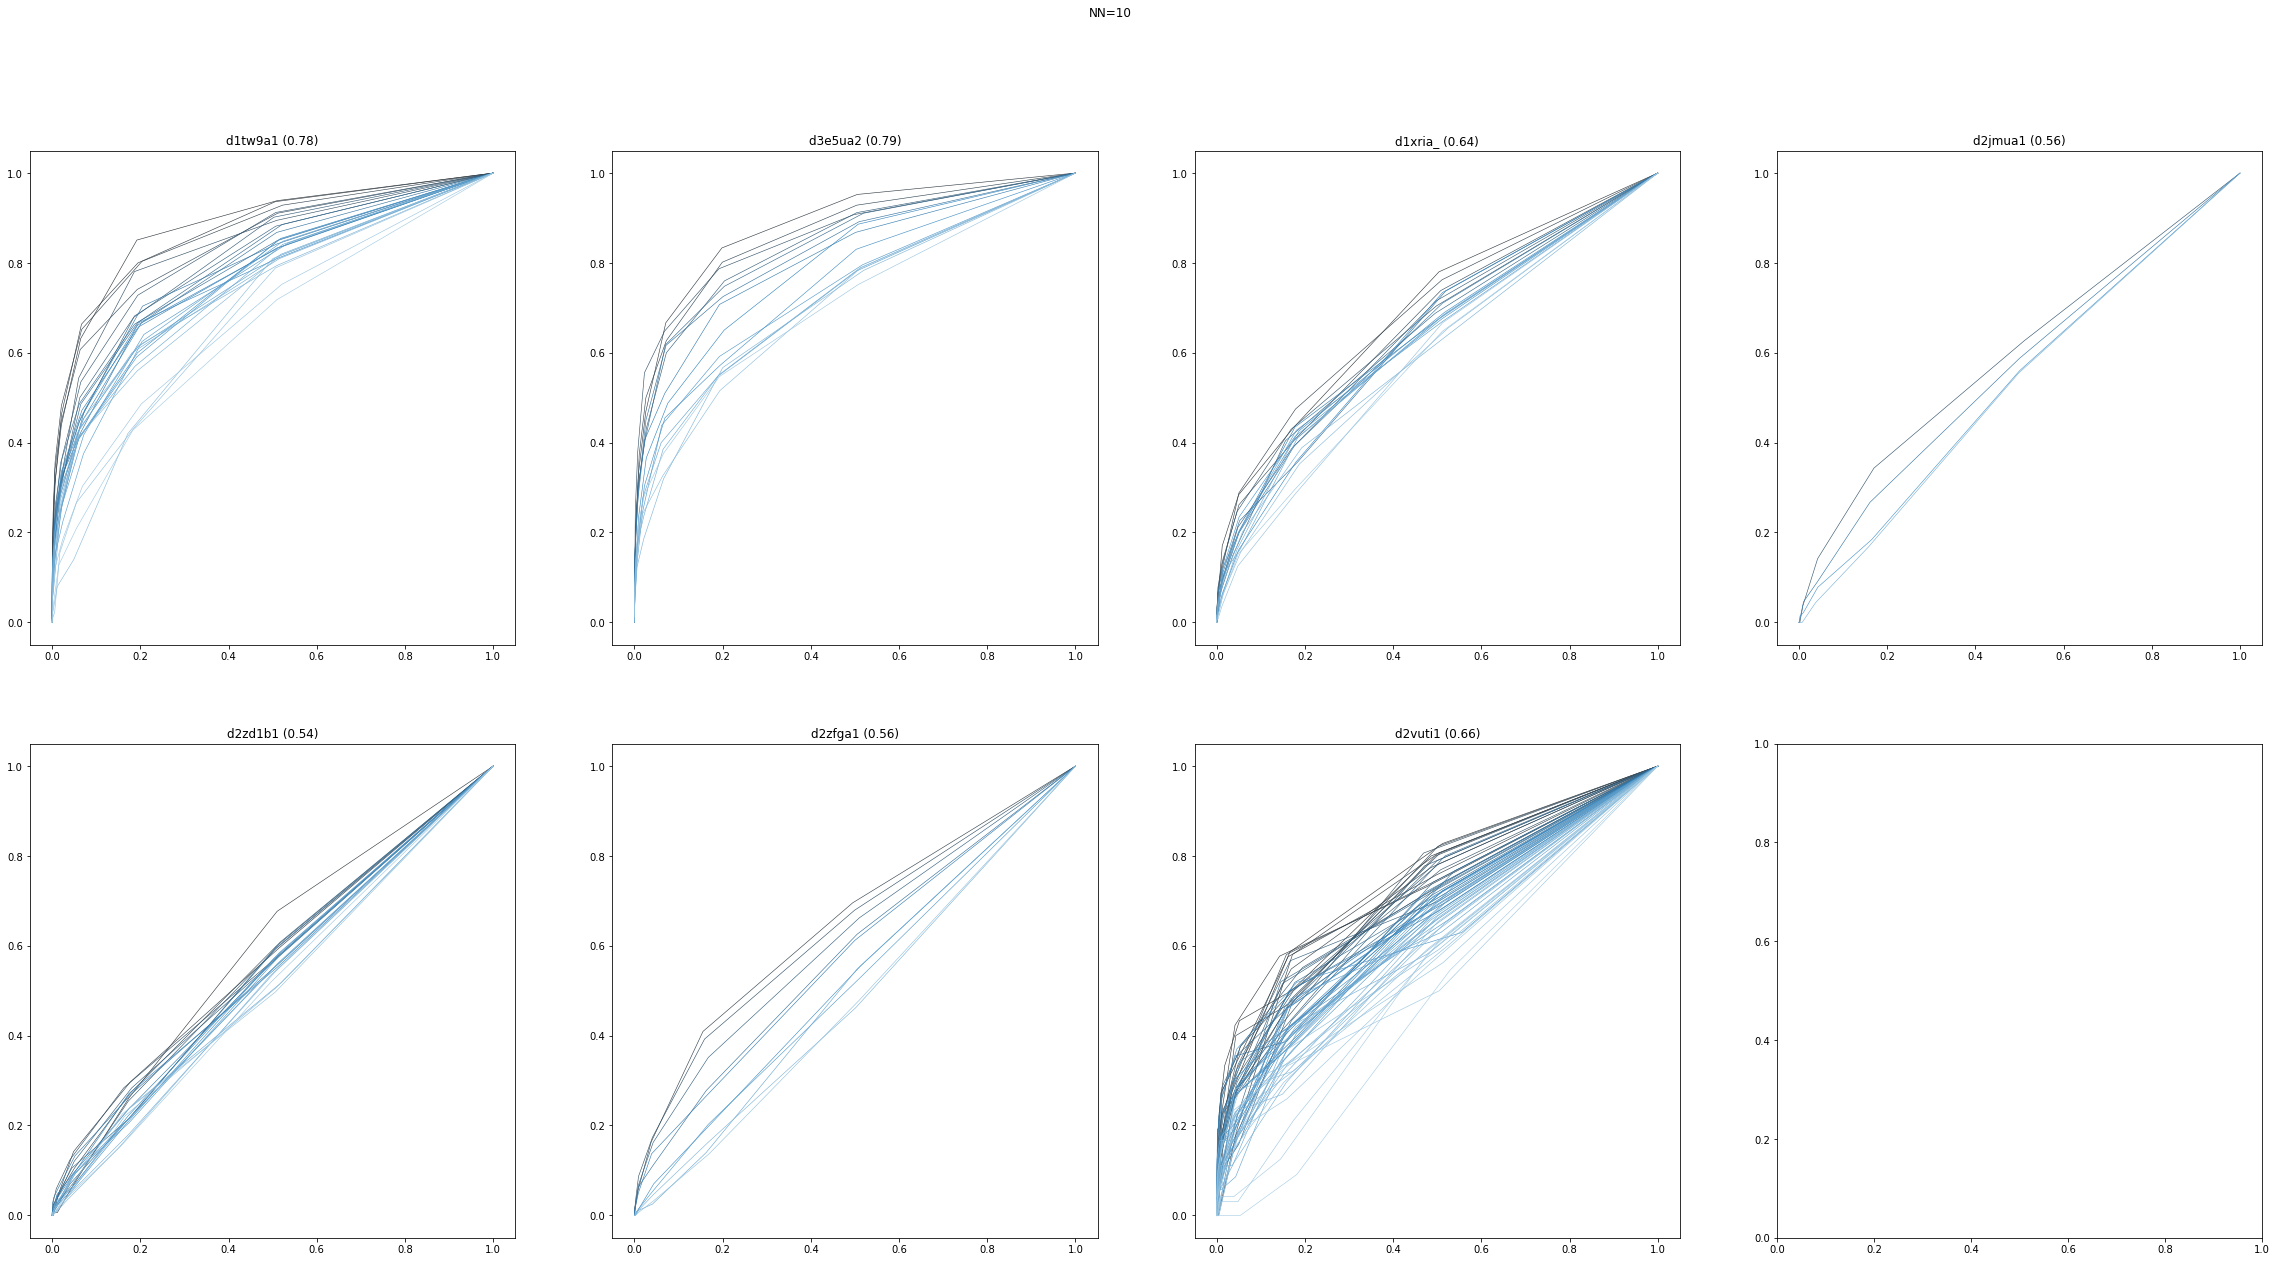

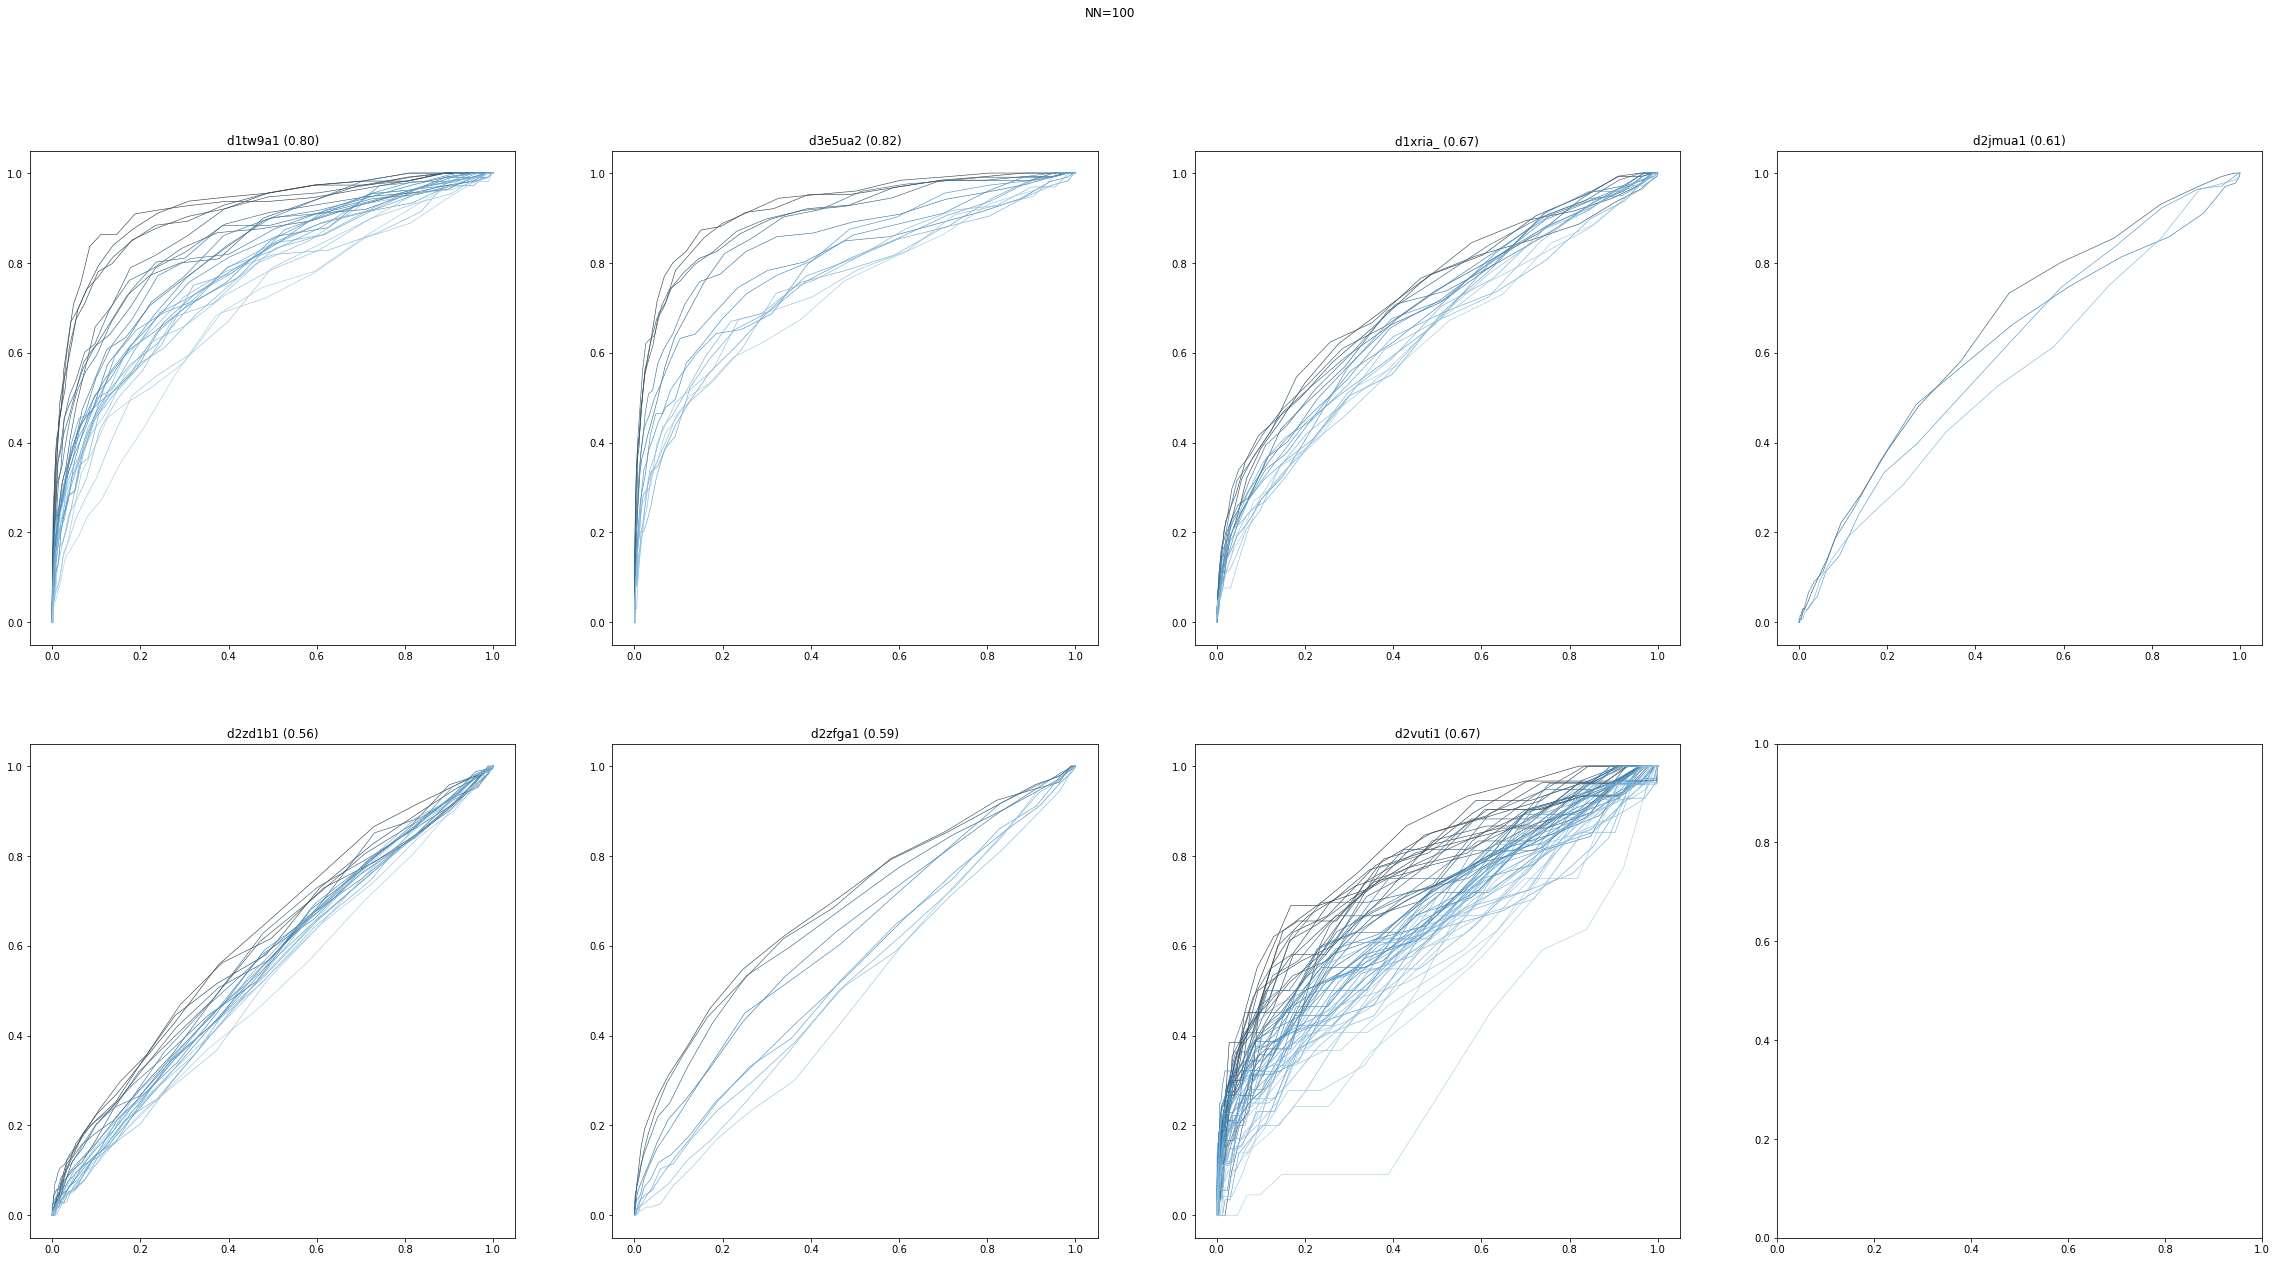

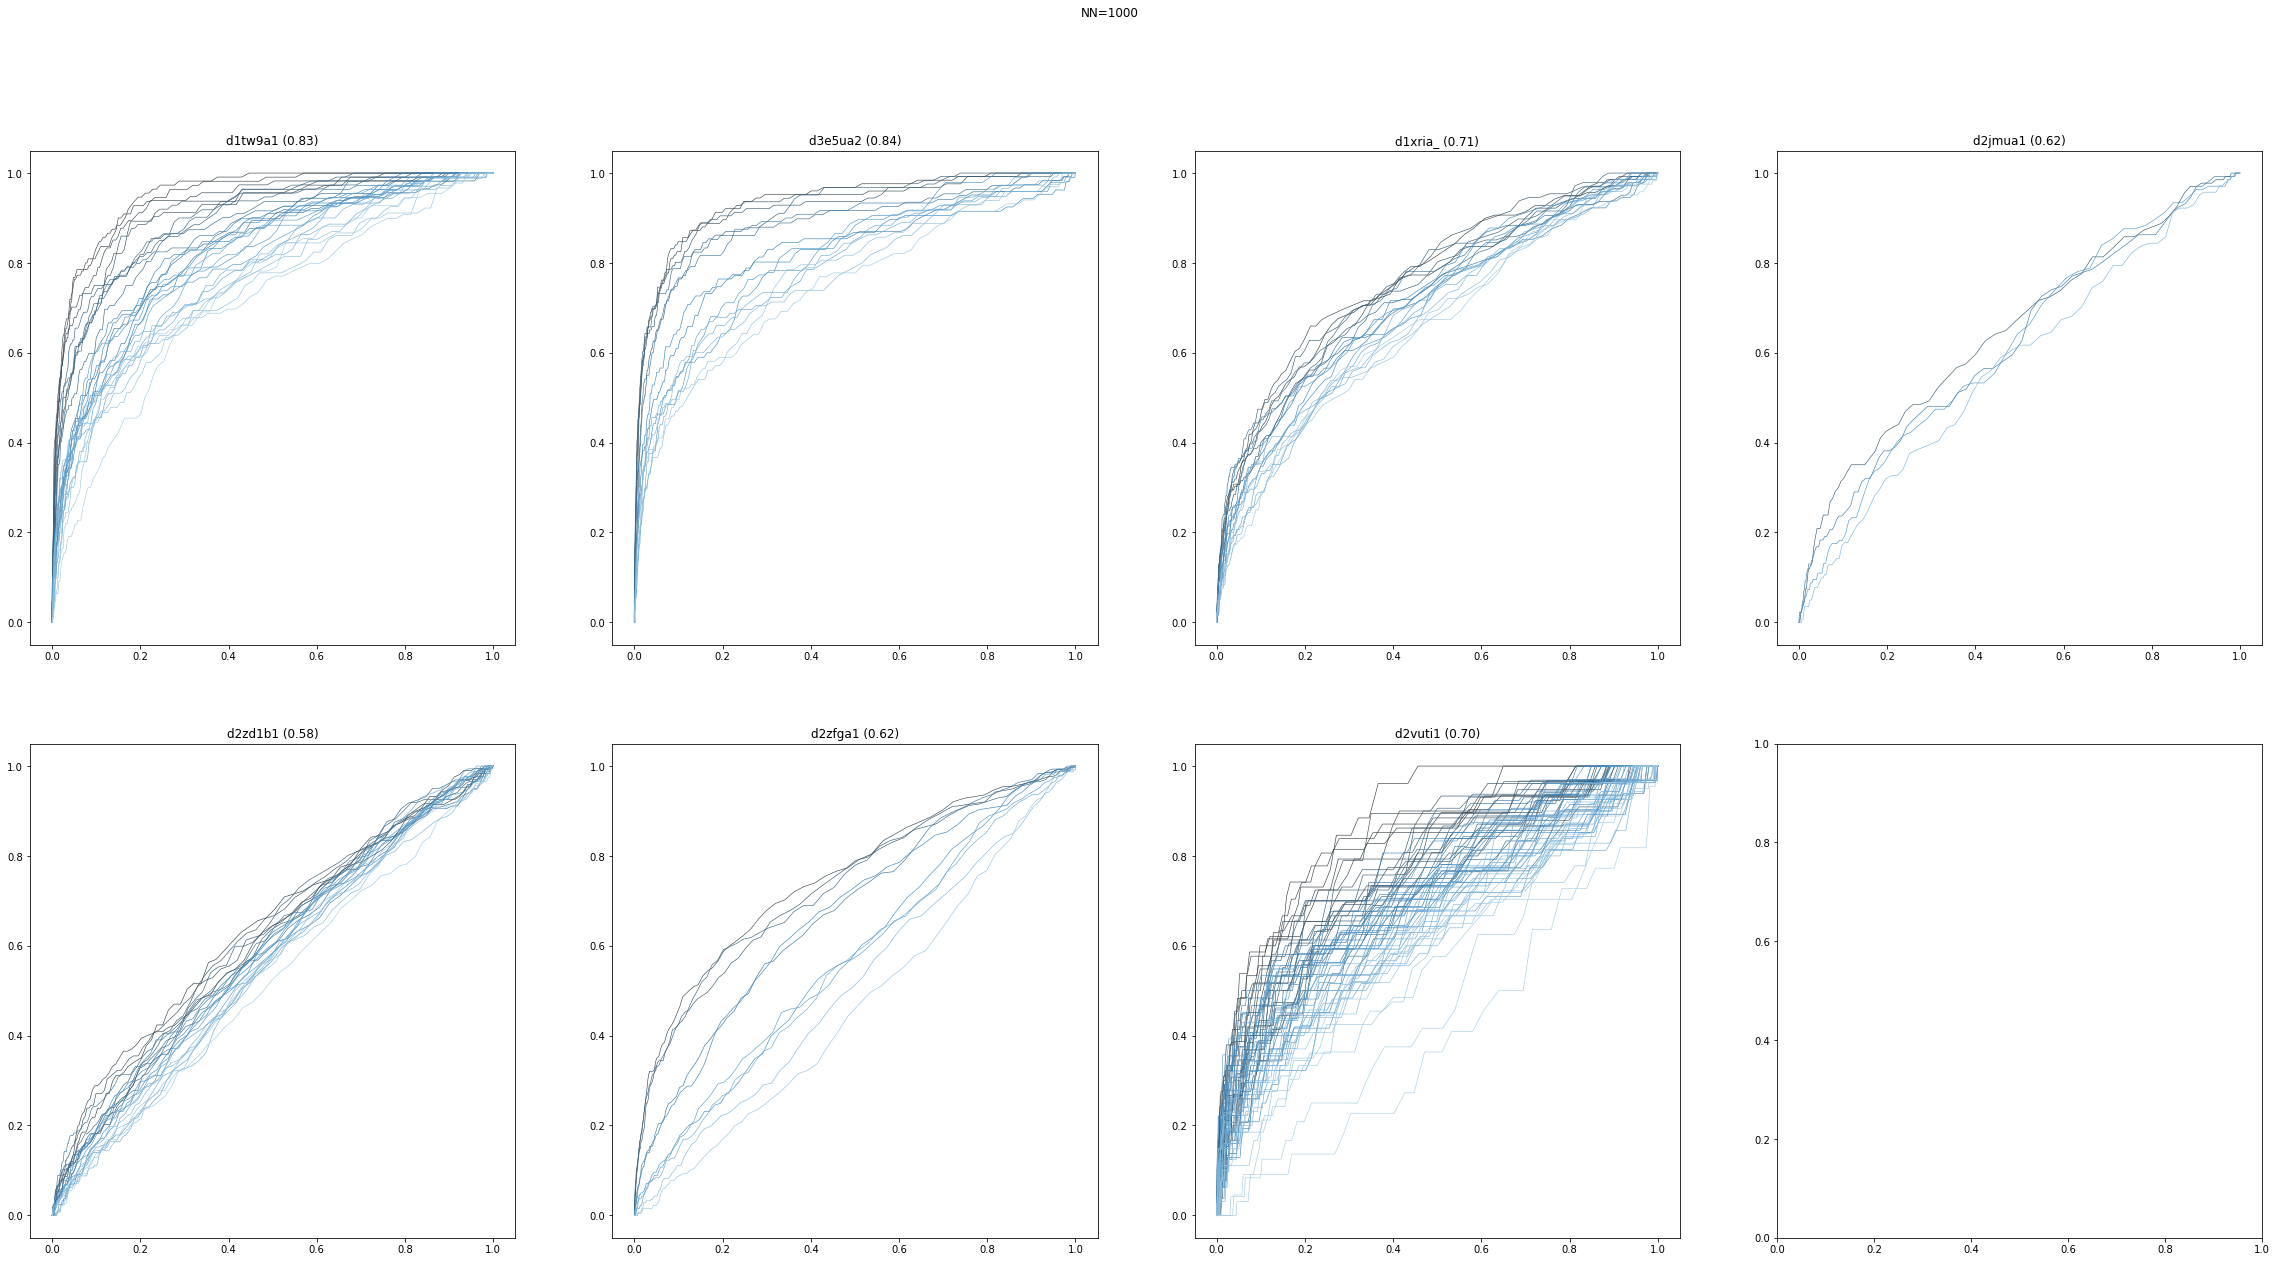

In [6]:
from pathlib import Path
import sys

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np
from sklearn import metrics
from matplotlib import pyplot
import seaborn
import pandas
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import get_validation_label

scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/hyperparam_validation_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
structural_alignments = SeqIO.index('../data/train/scop40_structural_alignment.fasta', 'fasta')

for nn in (10, 100, 1000):
    # Get ROC and calculate AUC
    auc_d, roc_d = {}, {}
    for query in test_domain:
        auc_d[query] = []
        roc_d[query] = {}
        roc_d[query]['fpr'] = []
        roc_d[query]['tpr'] = []
        roc_d[query]['index'] = []
        i = 0
        for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
            if domain not in scop40 or domain == query:
                continue
            test = get_validation_label(query, domain, structural_alignments, '../data/train/pssm').flatten()
            pred = np.load(f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn{nn}/{query}/{domain}.npy').flatten()
            assert test.shape[0] == pred.shape[0]
            fpr, tpr, _ = metrics.roc_curve(test, pred)
            auc_d[query].append(metrics.auc(fpr, tpr))
            roc_d[query]['fpr'].extend(fpr)
            roc_d[query]['tpr'].extend(tpr)
            roc_d[query]['index'].extend([i]*len(fpr))
            i += 1
    auc_df = pandas.DataFrame.from_dict(auc_d, orient='index').transpose()
    print(f'NN={nn}')
    display(auc_df.describe())
    # Visualize
    fig, axes = pyplot.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'NN={nn}')
    i = 0
    for query in test_domain:
        roc_df = pandas.DataFrame.from_dict(roc_d[query])
        seaborn.lineplot(x='fpr', y='tpr', data=roc_df, hue='index', linewidth=.6,
                         palette=seaborn.color_palette('Blues_d', len(auc_d[query])),
                         hue_order=sorted(range(len(auc_d[query])), key=lambda _: auc_d[query][_], reverse=True),
                         ax=axes[int(i/4), i%4], legend=False)
        avgauc = auc_df[query].mean()
        axes[int(i/4), i%4].set_title(f'{query} ({avgauc:.2f})')
        axes[int(i/4), i%4].set_xlabel('')
        axes[int(i/4), i%4].set_ylabel('')
        i += 1

# data reduction ratio by AUC

In [7]:
from pathlib import Path
import sys
import random
from concurrent.futures import ProcessPoolExecutor, wait

from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.predict import predict_by_flann


def process(n_neighbors):
    scop_root = Scop(dir_path='../data/train', version='1.75')
    scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
    args = []
    for query in np.load('../data/hyperparam_validation_domain_ids.npy'):
        for domain in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px'):
            if domain.sid in scop40 and domain.sid != query:
                args.append((query, domain.sid))
    random.shuffle(args)
    predict_by_flann('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001_x.npy',
                     '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.001_y.npy',
                     '../data/train/flann19_scop40_logscore_tmscore0.5_window5_ratio0.001',
                     n_neighbors,
                     f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.001_nn{n_neighbors}',
                     '../data/train/pssm',
                     args)

with ProcessPoolExecutor(max_workers=16) as executor:
    wait([executor.submit(process, 1000) for _ in range(16)])

100%|██████████| 162/162 [10:39<00:00,  3.95s/it]


Ratio=0.1


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.833233,0.842961,0.711428,0.616028,0.579128,0.623094,0.699841
std,0.065655,0.063728,0.035224,0.030520,0.028716,0.101104,0.076990
min,0.725789,0.748907,0.658169,0.575319,0.514929,0.466782,0.397811
25%,0.782596,0.796758,0.680086,0.606706,0.557401,0.558879,0.663016
50%,0.825683,0.825039,0.710482,0.619846,0.576413,0.620961,0.707707
75%,0.888781,0.902786,0.743271,0.629167,0.600687,0.717572,0.744224
max,0.950955,0.935461,0.759962,0.649100,0.623844,0.750090,0.857727


Ratio=0.01


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.795924,0.808354,0.678575,0.616843,0.577460,0.609143,0.642980
std,0.061500,0.064194,0.041770,0.015870,0.034257,0.072523,0.059483
min,0.700912,0.710690,0.614760,0.595291,0.507346,0.487709,0.461138
25%,0.748268,0.763093,0.646864,0.609733,0.551926,0.564157,0.611034
50%,0.784519,0.796815,0.670240,0.621227,0.579090,0.609931,0.643086
75%,0.843472,0.865455,0.720026,0.628337,0.598724,0.675217,0.678870
max,0.919072,0.899150,0.742676,0.629627,0.640136,0.697589,0.774602


Ratio=0.001


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.741718,0.762135,0.643310,0.586459,0.568510,0.575095,0.564794
std,0.065486,0.062731,0.031321,0.012131,0.025663,0.053276,0.057460
min,0.607683,0.680524,0.574052,0.574145,0.508160,0.476182,0.408543
25%,0.700992,0.702378,0.619375,0.579132,0.552149,0.549147,0.523997
50%,0.742752,0.756550,0.654062,0.584656,0.570629,0.567930,0.569680
75%,0.780649,0.817776,0.665239,0.591984,0.592740,0.612115,0.609808
max,0.852412,0.870229,0.693850,0.602380,0.602375,0.654551,0.691718


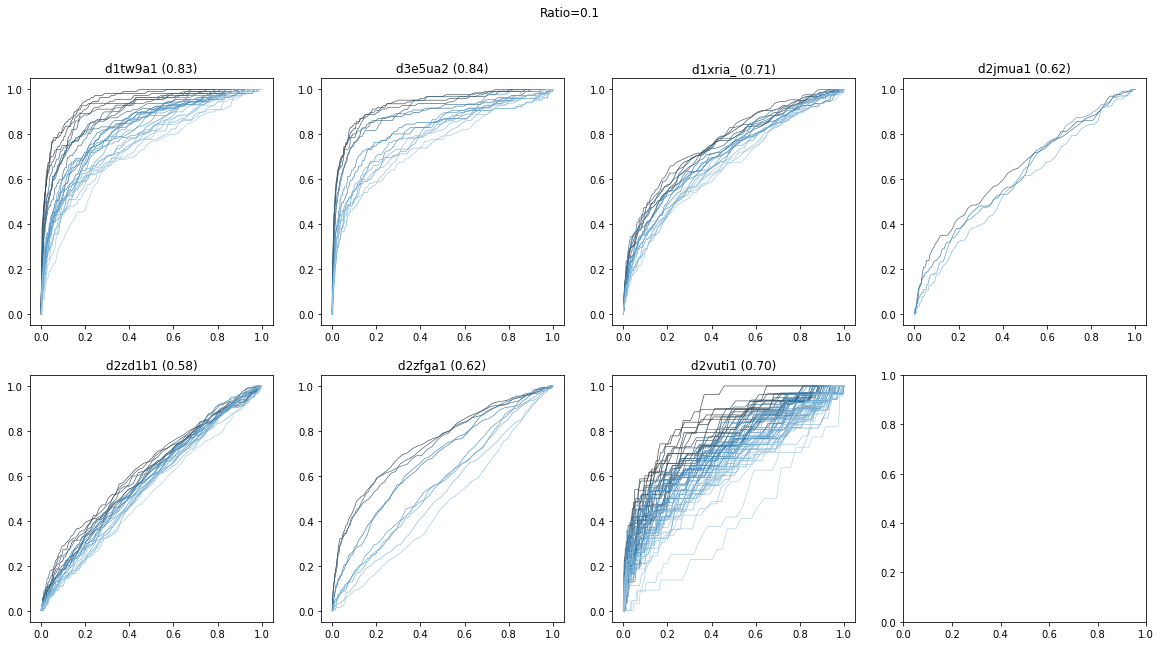

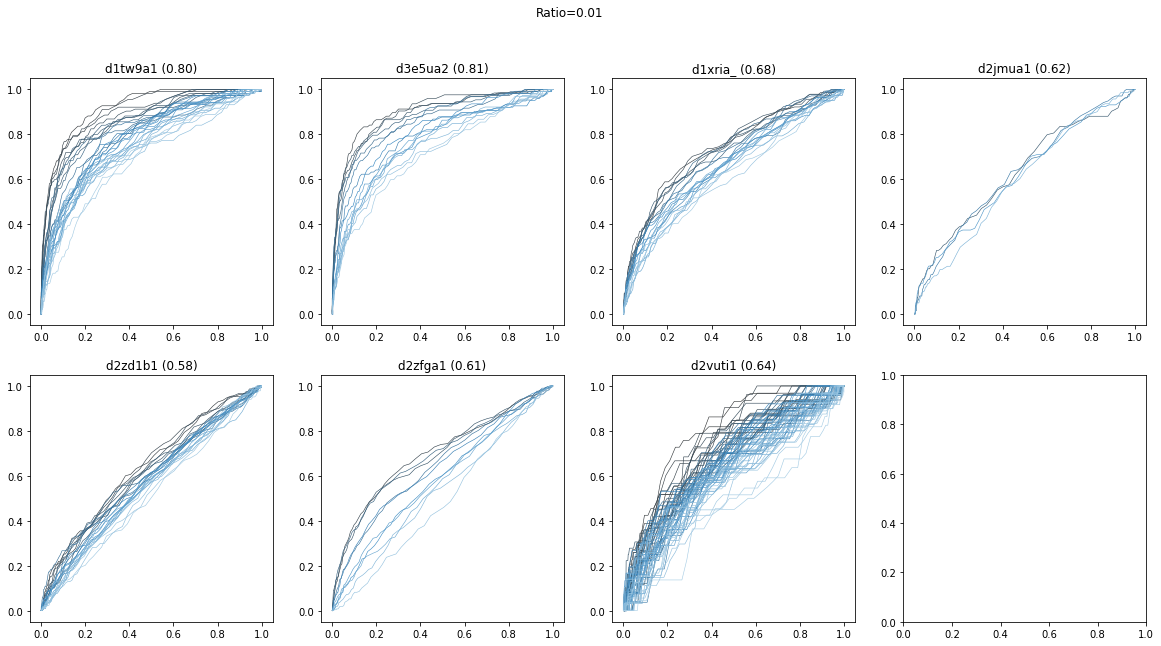

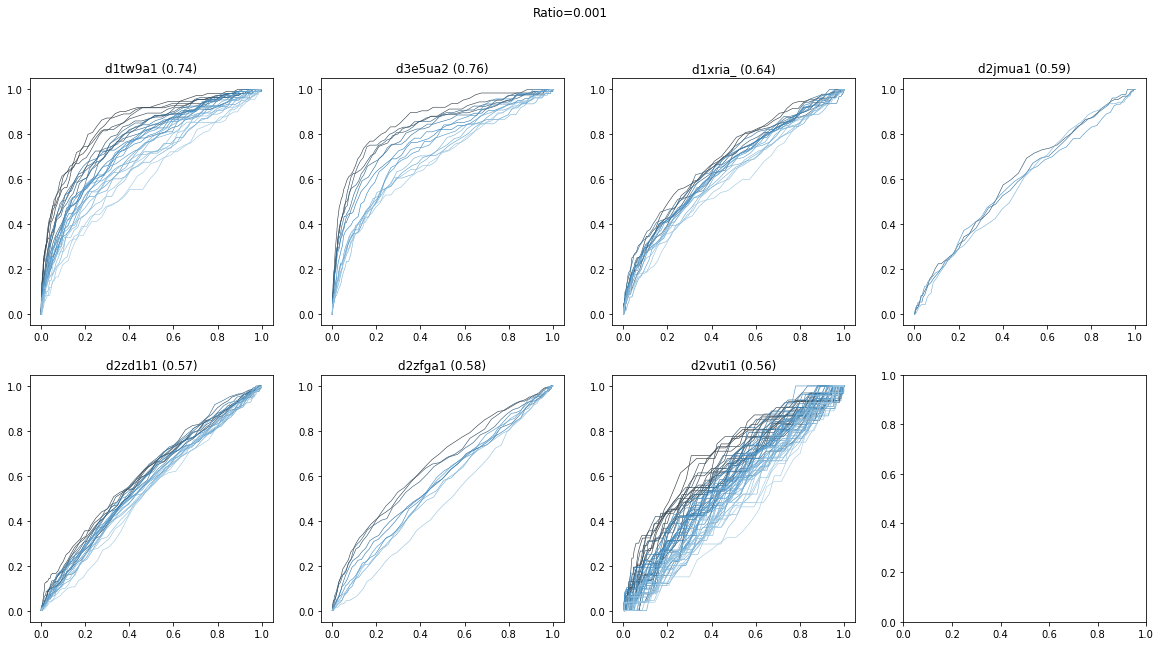

In [8]:
from pathlib import Path
import sys

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np
from sklearn import metrics
from matplotlib import pyplot
import seaborn
import pandas
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import get_validation_label

scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/hyperparam_validation_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
structural_alignments = SeqIO.index('../data/train/scop40_structural_alignment.fasta', 'fasta')

for ratio in (0.1, 0.01, 0.001):
    # Get ROC and calculate AUC
    auc_d, roc_d = {}, {}
    for query in test_domain:
        auc_d[query] = []
        roc_d[query] = {}
        roc_d[query]['fpr'] = []
        roc_d[query]['tpr'] = []
        roc_d[query]['index'] = []
        i = 0
        for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
            if domain not in scop40 or domain == query:
                continue
            test = get_validation_label(query, domain, structural_alignments, '../data/train/pssm').flatten()
            pred = np.load(f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio{ratio}_nn1000/{query}/{domain}.npy').flatten()
            assert test.shape[0] == pred.shape[0]
            fpr, tpr, _ = metrics.roc_curve(test, pred)
            auc_d[query].append(metrics.auc(fpr, tpr))
            roc_d[query]['fpr'].extend(fpr)
            roc_d[query]['tpr'].extend(tpr)
            roc_d[query]['index'].extend([i]*len(fpr))
            i += 1
    auc_df = pandas.DataFrame.from_dict(auc_d, orient='index').transpose()
    print(f'Ratio={ratio}')
    display(auc_df.describe())
    # Visualize
    fig, axes = pyplot.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Ratio={ratio}')
    i = 0
    for query in test_domain:
        roc_df = pandas.DataFrame.from_dict(roc_d[query])
        seaborn.lineplot(x='fpr', y='tpr', data=roc_df, hue='index', linewidth=.6,
                         palette=seaborn.color_palette('Blues_d', len(auc_d[query])),
                         hue_order=sorted(range(len(auc_d[query])), key=lambda _: auc_d[query][_], reverse=True),
                         ax=axes[int(i/4), i%4], legend=False)
        avgauc = auc_df[query].mean()
        axes[int(i/4), i%4].set_title(f'{query} ({avgauc:.2f})')
        axes[int(i/4), i%4].set_xlabel('')
        axes[int(i/4), i%4].set_ylabel('')
        i += 1

# Window size by AUC

In [1]:
from pathlib import Path
import sys
import random
from concurrent.futures import ProcessPoolExecutor, wait

from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.predict import predict_by_flann


def process(n_neighbors):
    scop_root = Scop(dir_path='../data/train', version='1.75')
    scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
    args = []
    for query in np.load('../data/hyperparam_validation_domain_ids.npy'):
        for domain in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px'):
            if domain.sid in scop40 and domain.sid != query:
                args.append((query, domain.sid))
    random.shuffle(args)
    predict_by_flann('../data/train/scop40_logscore_tmscore0.5_window3_ratio0.1_x.npy',
                     '../data/train/scop40_logscore_tmscore0.5_window3_ratio0.1_y.npy',
                     '../data/train/flann19_scop40_logscore_tmscore0.5_window3_ratio0.1',
                     n_neighbors,
                     f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window3_ratio0.1_nn{n_neighbors}',
                     '../data/train/pssm',
                     args)

with ProcessPoolExecutor(max_workers=16) as executor:
    wait([executor.submit(process, 1000) for _ in range(16)])

100%|██████████| 162/162 [1:55:05<00:00, 42.63s/it]  


In [2]:
from pathlib import Path
import sys

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np
from sklearn import metrics
from matplotlib import pyplot
import seaborn
import pandas
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import get_validation_label

scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/hyperparam_validation_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
structural_alignments = SeqIO.index('../data/train/scop40_structural_alignment.fasta', 'fasta')

for window in (1, 3, 5):
    # Get ROC and calculate AUC
    auc_d, roc_d = {}, {}
    for query in test_domain:
        auc_d[query] = []
        roc_d[query] = {}
        roc_d[query]['fpr'] = []
        roc_d[query]['tpr'] = []
        roc_d[query]['index'] = []
        i = 0
        for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
            if domain not in scop40 or domain == query:
                continue
            test = get_validation_label(query, domain, structural_alignments, '../data/train/pssm').flatten()
            try:
                pred = np.load(f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window{window}_ratio0.1_nn1000/{query}/{domain}.npy').flatten()
            except FileNotFoundError:
                continue
            assert test.shape[0] == pred.shape[0]
            fpr, tpr, _ = metrics.roc_curve(test, pred)
            auc_d[query].append(metrics.auc(fpr, tpr))
            roc_d[query]['fpr'].extend(fpr)
            roc_d[query]['tpr'].extend(tpr)
            roc_d[query]['index'].extend([i]*len(fpr))
            i += 1
    auc_df = pandas.DataFrame.from_dict(auc_d, orient='index').transpose()
    print(f'Window={window}')
    display(auc_df.describe())
    # Visualize
    fig, axes = pyplot.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Window={window}')
    i = 0
    for query in test_domain:
        roc_df = pandas.DataFrame.from_dict(roc_d[query])
        seaborn.lineplot(x='fpr', y='tpr', data=roc_df, hue='index', linewidth=.6,
                         palette=seaborn.color_palette('Blues_d', len(auc_d[query])),
                         hue_order=sorted(range(len(auc_d[query])), key=lambda _: auc_d[query][_], reverse=True),
                         ax=axes[int(i/4), i%4], legend=False)
        avgauc = auc_df[query].mean()
        axes[int(i/4), i%4].set_title(f'{query} ({avgauc:.2f})')
        axes[int(i/4), i%4].set_xlabel('')
        axes[int(i/4), i%4].set_ylabel('')
        i += 1

Window=1


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.722890,0.739065,0.646983,0.606175,0.567313,0.602381,0.593602
std,0.069220,0.067429,0.026444,0.018840,0.021797,0.049449,0.041230
min,0.610487,0.661878,0.597260,0.589241,0.513891,0.495939,0.514844
25%,0.676509,0.674975,0.631904,0.590598,0.556857,0.578078,0.570418
50%,0.706263,0.732165,0.646637,0.604519,0.566092,0.608590,0.593866
75%,0.771328,0.810065,0.667505,0.620096,0.576587,0.635291,0.617894
max,0.860166,0.830946,0.687609,0.626420,0.609697,0.665117,0.699312


Window=3


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.826839,0.820144,0.699648,0.593906,0.578347,0.625673,0.678335
std,0.062989,0.069079,0.036201,0.044512,0.023720,0.099867,0.065483
min,0.705018,0.721797,0.647087,0.541390,0.540859,0.458542,0.393884
25%,0.792854,0.771410,0.672358,0.567186,0.555369,0.562952,0.640824
50%,0.809930,0.800026,0.699948,0.595773,0.583761,0.621895,0.672770
75%,0.871418,0.890584,0.735050,0.622494,0.594143,0.719851,0.725253
max,0.943861,0.916985,0.761157,0.642690,0.617082,0.747563,0.814638


Window=5


,d1tw9a1,d3e5ua2,d1xria_,d2jmua1,d2zd1b1,d2zfga1,d2vuti1
count,28.000000,15.000000,19.000000,4.000000,22.000000,10.000000,64.000000
mean,0.833233,0.842961,0.711428,0.616028,0.579128,0.623094,0.699841
std,0.065655,0.063728,0.035224,0.030520,0.028716,0.101104,0.076990
min,0.725789,0.748907,0.658169,0.575319,0.514929,0.466782,0.397811
25%,0.782596,0.796758,0.680086,0.606706,0.557401,0.558879,0.663016
50%,0.825683,0.825039,0.710482,0.619846,0.576413,0.620961,0.707707
75%,0.888781,0.902786,0.743271,0.629167,0.600687,0.717572,0.744224
max,0.950955,0.935461,0.759962,0.649100,0.623844,0.750090,0.857727


# Gap penalty search

validation domains

['d2ij2a1' 'd3d85d1' 'd3etja2' 'd2iiza1' 'd1wuis1' 'd3dhwa1' 'd3d4ub1']

## Predict scores

In [3]:
from pathlib import Path
import sys
import random
from concurrent.futures import ProcessPoolExecutor, wait, ThreadPoolExecutor

from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.predict import predict_by_flann


def process():
    scop_root = Scop(dir_path='../data/train', version='1.75')
    scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
    args = []
    for query in np.load('../data/gap_validation_domain_ids.npy'):
        for domain in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px'):
            if domain.sid in scop40 and query != domain.sid:
                args.append((query, domain.sid))
    random.shuffle(args)
    predict_by_flann('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_x.npy',
                     '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_y.npy',
                     '../data/train/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1',
                     1000,
                     '../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000',
                     '../data/train/pssm',
                     args)

process()
# with ProcessPoolExecutor(max_workers=6) as executor:
#     wait([executor.submit(process) for _ in range(6)]) # 25min

100%|██████████| 223/223 [51:04<00:00, 18.77s/it]


In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor, wait
import os

from tqdm import tqdm_notebook as tqdm
import numpy as np
from Bio.SCOP import Scop
from Bio import SeqIO

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_alignment import alignment_local
from machina.generate_models import MachinaModel


test_domain = np.load('../data/gap_validation_domain_ids.npy')
scop_root = Scop(dir_path='../data/train', version='1.75')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
GAP_OPEN_LIST = (-0.0001, -0.001, -0.01, -0.1, -1)
GAP_EXTEND_LIST = (-0.0000001, -0.000001, -0.00001, -0.0001, -0.001, -0.01, -0.1, -1)

for GAP_OPEN in tqdm(GAP_OPEN_LIST):
    for GAP_EXTEND in tqdm(GAP_EXTEND_LIST):
        if GAP_OPEN > GAP_EXTEND:
            continue
        with ProcessPoolExecutor() as executor:
            args = []
            for query in test_domain:
                result_dir = Path(f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{query}')
                result_dir.mkdir(exist_ok=True, parents=True)
                for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
                    if domain not in scop40 or domain == query:
                        continue
                    if Path(result_dir/f'{domain}.npy').exists():
                        continue
                    args.append((f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000/{query}/{domain}.npy', query, domain))
            futures = [executor.submit(alignment_local, _[0], _[1], _[2], '../data/train/pssm', GAP_OPEN, GAP_EXTEND) for _ in args]
            for future in as_completed(futures):
                key, ali = future.result()
                np.save(f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{key[0]}/{key[1]}.npy', np.array(ali))


def _process(args):
    for a in args:
        MachinaModel().generate_protein_model(a[0], a[1], a[2], a[3], a[4])


for GAP_OPEN in tqdm(GAP_OPEN_LIST):
    for GAP_EXTEND in tqdm(GAP_EXTEND_LIST):
        if GAP_OPEN > GAP_EXTEND:
            continue
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            futures = []
            for query in test_domain:
                domains = [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')
                           if _.sid in scop40 and _.sid != query]
                args = [
                    (query, _,
                     f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{query}/{_}.npy',
                     f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{query}',
                     f'../data/train/pdbstyle-1.75/{_[2:4]}')
                    for _ in domains]
                futures.append(executor.submit(_process, args))
            wait(futures)

,0.0001,0.001,0.01,0.1,1
0.00001,223.0,223.0,223.0,223.0,223
0.0001,223.0,223.0,223.0,223.0,223
0.001,NaN,223.0,223.0,223.0,223
0.01,NaN,NaN,223.0,223.0,223
0.1,NaN,NaN,NaN,223.0,223
1,NaN,NaN,NaN,NaN,223


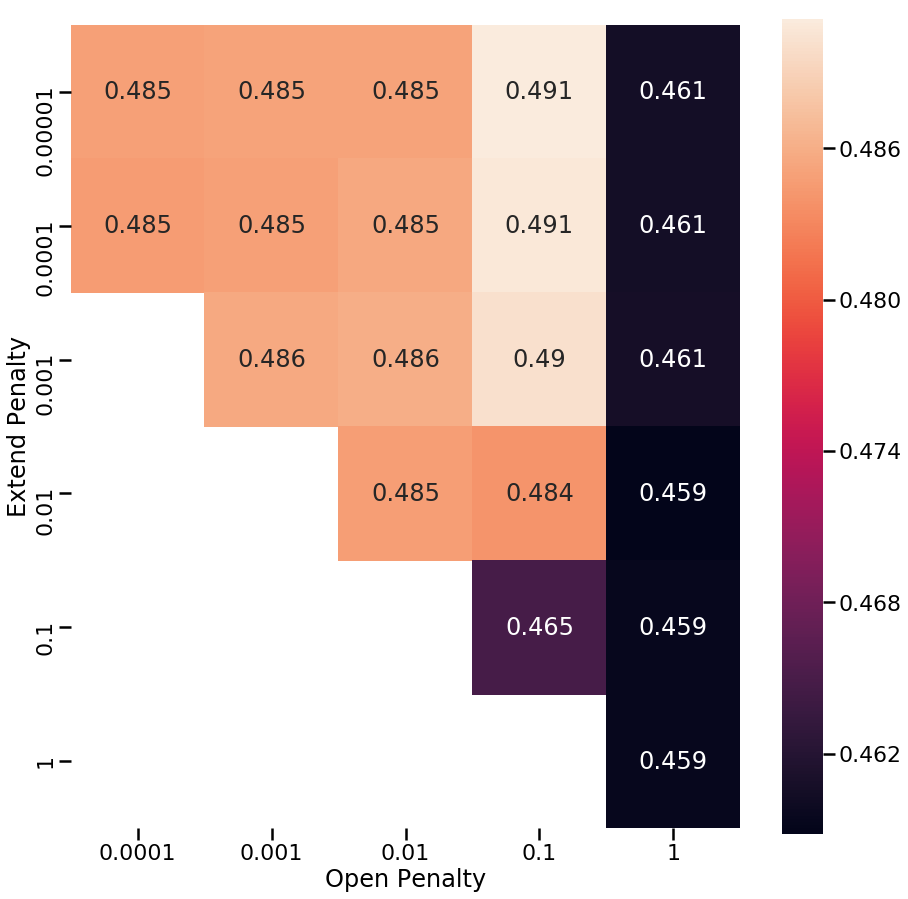

In [10]:
%matplotlib inline

import sys
from pathlib import Path

import pandas
from matplotlib import pyplot
import seaborn
import numpy as np
from Bio.SCOP import Scop
from Bio import SeqIO
from tqdm import tqdm_notebook as tqdm
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.TMtoolsCommandLine import TMalignCommandLine


scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/gap_validation_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
GAP_OPEN_LIST = (-0.0001, -0.001, -0.01, -0.1, -1)
GAP_EXTEND_LIST = (-0.00001, -0.0001, -0.001, -0.01, -0.1, -1)


def _process(model_pdb_path, native_pdb_path):
    tmalign = TMalignCommandLine(model_pdb_path, native_pdb_path)
    tmalign.run()
    if tmalign.tmscore is None:
        return None
    else:
        return tmalign.tmscore[1]

count_d = {}
grid_d = {}
for GAP_OPEN in tqdm(GAP_OPEN_LIST):
    count_d[f'{-GAP_OPEN}'] = {}
    grid_d[f'{-GAP_OPEN}'] = {}
    for GAP_EXTEND in tqdm(GAP_EXTEND_LIST):
        if GAP_OPEN > GAP_EXTEND:
            continue
        dir_prefix = f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}'
        scores = []
        for query in test_domain:
            domains = [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')
                       if _.sid in scop40 and _.sid != query and Path(f'{dir_prefix}/{query}/{_.sid}.pdb').exists()]
            for domain in domains:
                scores.append(_process(f'{dir_prefix}/{query}/{domain}.pdb', f'../data/train/pdbstyle-1.75/{query[2:4]}/{query}.ent'))
        if GAP_EXTEND == -0.00001:
            count_d[f'{-GAP_OPEN}'][f'{-GAP_EXTEND:.5f}'] = np.array(scores).shape[0]
            grid_d[f'{-GAP_OPEN}'][f'{-GAP_EXTEND:.5f}'] = np.array(scores).mean()
        else:
            count_d[f'{-GAP_OPEN}'][f'{-GAP_EXTEND}'] = np.array(scores).shape[0]
            grid_d[f'{-GAP_OPEN}'][f'{-GAP_EXTEND}'] = np.array(scores).mean()
display(pandas.DataFrame.from_dict(count_d))
grid_df = pandas.DataFrame.from_dict(grid_d)

seaborn.set_context('poster')
fig, ax = pyplot.subplots(figsize=(15, 15))
seaborn.heatmap(grid_df, ax=ax, linewidths=0, square=True, annot=True, fmt='.3g')
ax.set_ylabel('Extend Penalty')
ax.set_xlabel('Open Penalty')
fig.savefig('gap_penalty_search.pdf', bbox_inches='tight', pad_inches = 0)